In [242]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import librosa
import itertools
import matplotlib.pyplot as plt
import random
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset

# hyperparameters
# samplerate is 16000 for wav
samplerate = 50 * 22
# cycle rate is 50 Hz
cycle_rate = 50
num_epochs = 300
hidden_size = 256
second_hidden_size = 256
third_hidden_size = 256
learning_rate = 0.001
batch_size = 4

adult_directory = r'F:\A2E\adults-trimmed'
child_directory = r'F:\A2E\children-trimmed'

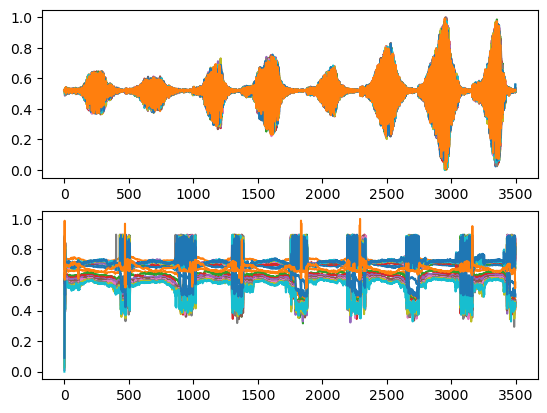

In [298]:
wav_files = r'F:\A2E\testfile\test_Voice_EGG.wav'
cycle_files = r'F:\A2E\testfile\test_Log_50Hz.csv'

# load wav file the first channel
wav, _ = librosa.load(wav_files, sr=samplerate, mono=False)
wav_data = wav[0, :]

# load csv file
cycle_data = pd.read_csv(cycle_files, delimiter=',', encoding='utf-8-sig')

# useful parts are 13:end cols and convert to list
cycle_data = cycle_data.iloc[:, 13:].values.tolist()

# min-max normalization for wav and cycle
wav_data = np.array(wav_data)
cycle_data = np.array(cycle_data)
wav = (wav_data - np.min(wav_data)) / (np.max(wav_data) - np.min(wav_data))
cycle = (cycle_data - np.min(cycle_data)) / (np.max(cycle_data) - np.min(cycle_data))

# remove the silence part of wav
intervals = librosa.effects.split(wav, top_db=20)[0]
wav = wav[intervals[0]:intervals[1]]


# segment the wav file by samplerate / cycle_rate, discard the last segments to match the length of cycle
segmented_wav = []
for i in range(0, len(wav), int(samplerate / cycle_rate)):
    segmented_wav.append(wav[i:i + int(samplerate / cycle_rate)])
segmented_wav = segmented_wav[:len(cycle)]

# plot the segmented wav and cycle
plt.figure()
plt.subplot(211)
plt.plot(segmented_wav)
plt.subplot(212)
plt.plot(cycle)
plt.show()


In [299]:
class VoiceDataset(Dataset):
    def __init__(self, wav, cycle):
        self.wav = wav  # This should be a list or array of segments
        self.cycle = cycle  # This should be a list or array of corresponding segments

    def __len__(self):
        return len(self.wav)

    def __getitem__(self, idx):
        wav_segment = self.wav[idx]
        cycle_segment = self.cycle[idx]

        input_tensor = torch.tensor(wav_segment, dtype=torch.float32)
        target_tensor = torch.tensor(cycle_segment, dtype=torch.float32)

        return input_tensor, target_tensor
    
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15):
    total_size = len(dataset)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size

    # Randomly split the dataset into train, validation, and test
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

    

dataset = VoiceDataset(segmented_wav, cycle)

# Split the dataset
train_dataset, val_dataset, test_dataset = split_dataset(dataset)


# create the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# check the shape of the loader
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

class RegressionNetwork(nn.Module):
    def __init__(self, input_size=22, hidden_size=256, output_size=22):
        super(RegressionNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size * 2)
        self.layer2 = nn.Linear(hidden_size * 2, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        return x


torch.Size([4, 22])
torch.Size([4, 22])


Epoch 1/300, Training Loss: 0.0116, Validation Loss: 0.0031, lr: 0.001000
Epoch 2/300, Training Loss: 0.0059, Validation Loss: 0.0042, lr: 0.001000
Epoch 3/300, Training Loss: 0.0010, Validation Loss: 0.0029, lr: 0.001000
Epoch 4/300, Training Loss: 0.0017, Validation Loss: 0.0028, lr: 0.001000
Epoch 5/300, Training Loss: 0.0039, Validation Loss: 0.0026, lr: 0.001000
Epoch 6/300, Training Loss: 0.0019, Validation Loss: 0.0028, lr: 0.001000
Epoch 7/300, Training Loss: 0.0012, Validation Loss: 0.0028, lr: 0.001000
Epoch 8/300, Training Loss: 0.0043, Validation Loss: 0.0028, lr: 0.001000
Epoch 9/300, Training Loss: 0.0048, Validation Loss: 0.0034, lr: 0.001000
Epoch 10/300, Training Loss: 0.0015, Validation Loss: 0.0028, lr: 0.001000
Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/300, Training Loss: 0.0034, Validation Loss: 0.0027, lr: 0.000100
Epoch 12/300, Training Loss: 0.0022, Validation Loss: 0.0025, lr: 0.000100
Epoch 13/300, Training Loss: 0.0034, Validation

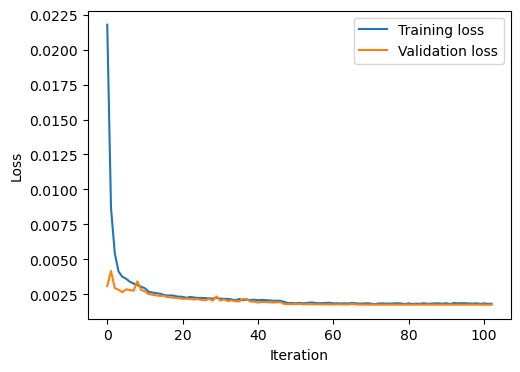

In [300]:
model = RegressionNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

best_val_loss = float('inf')
patience = 50  # Adjust as needed
patience_counter = 0

num_epochs = 300

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
lr_rates = []


for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    epoch_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()  # Accumulate batch loss for the epoch

    # Calculate average training loss for the epoch
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Calculate validation loss
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)  # Store validation loss

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_rates.append(current_lr)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}, lr: {current_lr:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model checkpoint if desired
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Plotting the training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

Test Loss: 0.0018


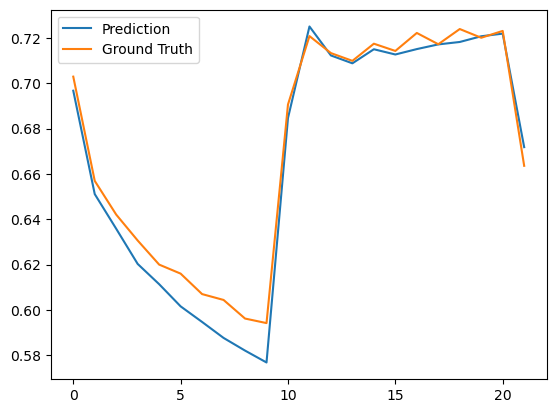

In [301]:
# predict the test data
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
       
print(f"Test Loss: {test_loss/len(test_loader):.4f}")

# plot 1 random sample from test dataset, output is the prediction, target is the ground truth
random_idx = random.randint(0, len(test_dataset))
random_sample = test_dataset[random_idx]
random_input = random_sample[0]
random_target = random_sample[1]
random_input = random_input.to(device)
random_target = random_target.to(device)
random_output = model(random_input)
random_output = random_output.cpu().detach().numpy()
random_target = random_target.cpu().detach().numpy()

plt.figure()
plt.plot(random_output, label='Prediction')
plt.plot(random_target, label='Ground Truth')
plt.legend()
plt.show()





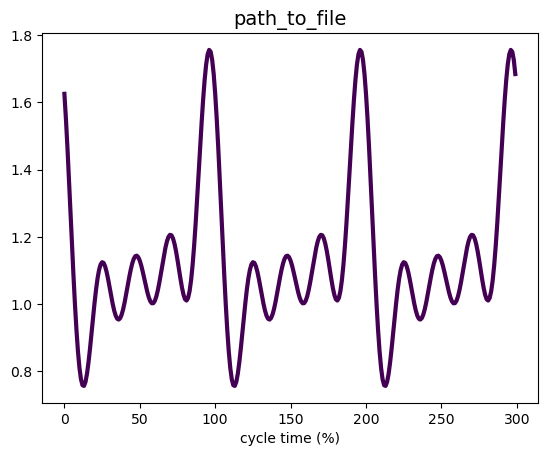

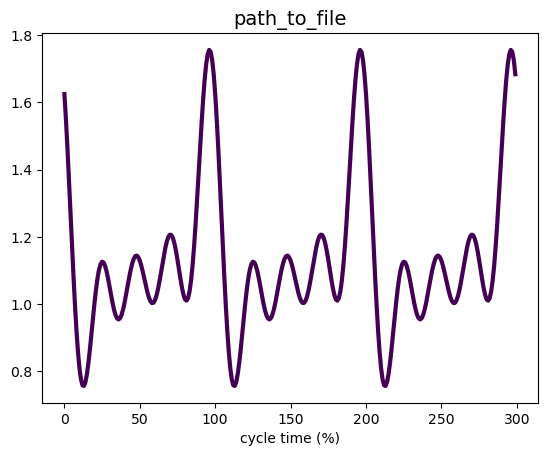

In [306]:
# convert back to EGG signal
import numpy as np

def synthEGGfromArrays(levels, phases, nHarmonics, points, periods):
    actualAmps = np.power(10, levels[:nHarmonics] / 2.0)
    actualPhases = phases[:nHarmonics]
    nPeriod = points
    nStep = 2 * np.pi / nPeriod
    
    timeStruct = {
        'qC': 0.5,
        'maxDegg': 1.0,
        'p2pAmpl': 1.0,
        'iC': 0.0
    }

    # Compute periods of the waveshapes
    harmonics = np.zeros((nHarmonics, int(round(periods * nPeriod))))
    for k in range(nHarmonics):
        for i in range(int(round(periods * nPeriod))):
            harmonics[k, i] = actualAmps[k] * np.cos((i * (k * nStep)) + actualPhases[k])
    
    wave = np.sum(harmonics, axis=0)
    aMax = np.max(wave)
    aMin = np.min(wave)
    timeStruct['p2pAmpl'] = aMax - aMin
    wave = wave / (aMax - aMin)
    aMin = np.min(wave)
    timeStruct['qC'] = np.sum((wave[:nPeriod] - aMin)) / nPeriod
    wPeriod = wave[:nPeriod + 1]
    wPeriodDiff = wave[1:nPeriod + 1] - wave[:nPeriod]
    timeStruct['maxDegg'] = np.max(wPeriodDiff) / (0.5 * np.sin(2 * np.pi / points))
    timeStruct['iC'] = timeStruct['qC'] * np.log10(timeStruct['maxDegg'])
    
    egg = wave

    return egg, timeStruct

#Example usage:
# min-max convert back, based on wav = (wav - wav.min()) / (wav.max() - wav.min())
random_output = random_output * (wav.max() - wav.min()) + wav.min()
random_target = random_target * (wav.max() - wav.min()) + wav.min()

# levels are the first 11 cols of output, phases are the last 11 cols of output
levels = random_output[:11]
phases = random_output[11:]
original_levels = random_target[:11]
original_phases = random_target[11:]

nHarmonics = 5
points = 100
periods = 3
egg, timeStruct = synthEGGfromArrays(levels, phases, nHarmonics, points, periods)
original_egg, original_timeStruct = synthEGGfromArrays(original_levels, original_phases, nHarmonics, points, periods)

import matplotlib.pyplot as plt
import os
import numpy as np

def plotEGG(waves, filename):
    # Check if waves is 1D or 2D
    nCurves = 1 if waves.ndim == 1 else waves.shape[1]
    
    plt.figure()
    title = os.path.splitext(os.path.basename(filename))[0]
    plt.title(title, fontsize=14)
    
    # Generate a color map range, using a maximum of either nCurves or 1
    colors = plt.cm.viridis(np.linspace(0, 0.7, max(nCurves, 1)))
    
    # Plot each curve
    if nCurves == 1:
        y = waves + 1  # If only one curve, offset it by 1
        plt.plot(y, linewidth=3, color=colors[0])
    else:
        for i in range(nCurves):
            y = waves[:, i] + (nCurves - i)
            plt.plot(y, linewidth=3, color=colors[i])
    
    plt.xlabel('cycle time (%)')
    plt.show()

# Example usage:
waves = np.array(...)  # Replace with actual waves data
filename = 'path_to_file'  # Replace with actual file path
plotEGG(egg, filename)
plotEGG(original_egg, filename)

